In [1]:
from cil.framework import ImageGeometry
from cil.optimisation.operators import LinearOperator, GradientOperator, BlurringOperator
from cil.optimisation.functions import Function
from cil.optimisation.functions import MixedL21Norm, LeastSquares, L2NormSquared, L1Norm, ZeroFunction
from cil.optimisation.algorithms import FISTA, ISTA
from cil.utilities import dataexample, noise
from cil.utilities.display import show2D
import numpy as np
import matplotlib.pyplot as plt
from cil.optimisation.algorithms import ProxSkip
from cil.optimisation.utilities import MetricsDiagnostics, StatisticsDiagnostics, AlgorithmDiagnostics, RSE
from TotalVariation import TotalVariationNew
import zarr
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['font.size'] = 20

In [4]:
class StoppingCriterion(AlgorithmDiagnostics):

    def __init__(self, epsilon):

        self.epsilon = epsilon
        super(StoppingCriterion, self).__init__(verbose=0)

        self.should_stop = False
        
    def _should_stop(self):

        return self.should_stop       
            
    def __call__(self, algo):

        if algo.iteration==0:
            algo.should_stop = self._should_stop
        
        if (algo.rse[-1]<=self.epsilon):        
            self.should_stop = True                 
            print("Stop at {} time {} ".format(algo.iteration, np.sum(algo.timing)))


def NRSE(x, y, **kwargs):
    """
     root squared error between two numpy arrays
    """
    return np.sqrt(np.sum(np.abs(x - y)**2))/np.sqrt(np.sum(x**2))

SSIM_dr = lambda x, y: SSIM(x, y, data_range=x.max()-x.min())
PSNR_dr = lambda x, y: PSNR(x, y, data_range=x.max()-x.min())


# # Load data
data = dataexample.SHAPES.get()
ig = data.geometry


# Parameters for point spread function PSF (size and std)
ks          = 10; 
ksigma      = 5;

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

# Create blurring operator and apply to clean image to produce blurred and display.
BOP = BlurringOperator(PSF,ig)


blurred_noisy = zarr.load("results/noisy_blurry_shapes_var_0.001_seed_10.zarr")


blurred_noisy_cil = ig.allocate()
blurred_noisy_cil.fill(blurred_noisy["blurred_noisy"])

alpha = 0.025

# compare vs pdhg precond
pdhg_precond_optimal_info = zarr.load("results/pdhg_optimal_precond_shapes_tv_alpha_{}.zarr".format(alpha))
pdhg_precond_optimal_np = pdhg_precond_optimal_info["solution"]
pdhg_precond_optimal_objective = pdhg_precond_optimal_info["objective"]

pdhg_precond_optimal = ig.allocate()
pdhg_precond_optimal.fill(pdhg_precond_optimal_np)


G100 = alpha * TotalVariationNew(max_iteration=100, warm_start=True)
F = LeastSquares(A=BOP, b=blurred_noisy_cil, c=0.5)

cb1 = MetricsDiagnostics(reference_image=pdhg_precond_optimal, 
                         metrics_dict={"rse":NRSE, "ssim":SSIM_dr, "psnr":PSNR_dr})  


num_runs = 1
step_size = 1.
num_iterations = 3000
initial = ig.allocate()

probs = [0.05]

for run in range(num_runs):

        cb2 = StoppingCriterion(epsilon=0.99e-5)
        fista = FISTA(initial=initial, f=F, g=G100, max_iteration=num_iterations, update_objective_interval=1, step_size=step_size)
        fista.run(verbose=0, callback=[cb1, cb2])

        cb2 = StoppingCriterion(epsilon=0.99e-5)
        ista = ISTA(initial=initial, f=F, g=G100, max_iteration=num_iterations, update_objective_interval=1, step_size=step_size)
        ista.run(verbose=0, callback=[cb1, cb2])    


        for prob in probs:
    
            cb2 = StoppingCriterion(epsilon=0.99e-5)
            proxskip = ProxSkip(initial = initial, f = F, step_size = step_size, g=G100, 
                        update_objective_interval = 1, prob=prob, seed=40,
                        max_iteration = num_iterations) 
            proxskip.run(verbose=0, callback=[cb1, cb2]) 

Stop at 544 time 80.14004278182983 
Stop at 2326 time 350.16107845306396 
Stop at 2401 time 38.33346104621887 


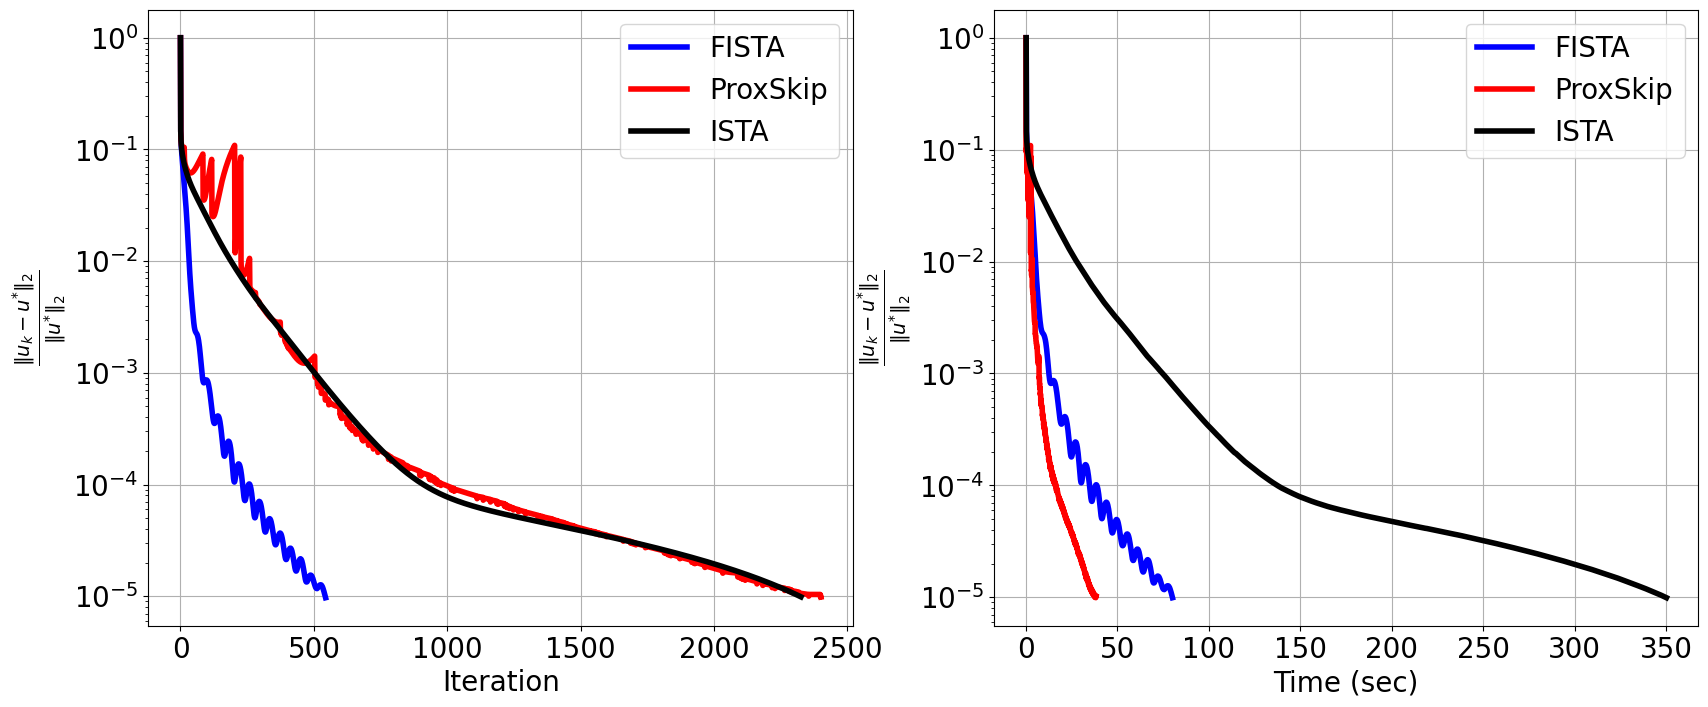

In [11]:
fig, axs = plt.subplots(1,2, figsize=(20,8))
axs[0].semilogy(fista.rse, label="FISTA", color="blue")
axs[0].semilogy(proxskip.rse, label="ProxSkip", color="red")
axs[0].semilogy(ista.rse, label="ISTA", color="black")
axs[0].set_ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
axs[0].set_xlabel(r"Iteration")
axs[0].grid(which="major")
axs[0].legend()

axs[1].semilogy(np.cumsum(fista.timing), fista.rse[:-1], label="FISTA", color="blue")
axs[1].semilogy(np.cumsum(proxskip.timing), proxskip.rse[:-1], label="ProxSkip", color="red")
axs[1].semilogy(np.cumsum(ista.timing), ista.rse[:-1], label="ISTA", color="black")
axs[1].set_ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
axs[1].set_xlabel(r"Time (sec)")
axs[1].grid(which="major")
axs[1].legend()
plt.show()